# **NDWI With Dask**

This tutorial notebook demonstrates how to find, visualize, and analyze the Normalized Difference Water Index with Landsat 8 imagery, efficiently using Dask. Landsat 8 has a spatial resolution of 30 meters and temporal resolution of 16 days, which makes it ideal for medium scale imagery for water mapping. We will be focusing on the area around Cultus lake, in the Fraser Valley, British Columbia.


**What is NDWI?**

The Normalized Difference Water Index (NDWI) is used for the water bodies analysis, differentiating water from dry land. Water has a low reflectance and strong absorbability in the visible infrared wavelengths range.

The index makes use of visible green light and near-infrared radiation to enhance the open water features and removing presence of soil and vegetative features. The NDWI may also estimate the turbidity of water bodies.  


**How is NDWI calculated?**

There are two way of calculating NDWI.

1. To monitor changes in the water content of water bodies, using green and near-infrared (NIR) bands.
    * **`NDWI = (Green-NIR)/(Green+NIR)`**
2. To monitor changes in the water content of leaves, using the near-infrared (NIR) and shortwave infrared (SWIR) bands. 
    * `NDWI = (NIR-SWIR)/(NIR+SWIR)`

Since we want to analyze the change in water content in the lakes located within our raster image, we will be using the **first method** with the Landsat Band 3 for Green channel and Band 5 for NIR channel. 

**What do NDWI values represent?**

Similar to the results of NDVI, the NDWI formula generates a value between -1.0 to 1.0. Water bodies NDWI value is usually greater than 0.5, while vegetation has much smaller values which makes it easy to distinguish vegetation from water bodies. Build-up features having positive values lies between 0 to 0.2.


## 1. Initialize your Dask Gateway Clusters
Since we want to use eight years of data for our analysis, running the computation using the cores of the machine we are running this notebook on is not ideal. Let's connect to Dask Gateway so we can create a cluster that can run our work.

For now, we will set our cluster to scale the workers to 30, because of the amount of data we will be working with. 

In [33]:
# First initialize the modules 
import os
import re
import glob
import json
import urllib
import datetime
import requests
import stackstac
import planetary_computer

import hvplot.xarray
import holoviews
import dask
import rasterio

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xrspatial.multispectral as ms

from pystac_client import Client
from dask_gateway import Gateway
from IPython.display import clear_output
from xrspatial.focal import mean, focal_stats, hotspots
from dask.distributed import wait, progress, performance_report

In [35]:
gateway = Gateway()

# Cluster configuration 
options = gateway.cluster_options()
cluster = gateway.new_cluster(options)

In [36]:
# Scale the cluster
workers = 30
cluster.scale(workers) 

In [37]:
# Assign client to this cluster so Dask knows to use it for computations
client = cluster.get_client() 

In [38]:
client.wait_for_workers(workers-3)
cluster

In [39]:
gateway.list_clusters()

[ClusterReport<name=pangeo.62976ba2a2cc4ad2adaac00da76585b5, status=RUNNING>]

## 2. Get the Landsat 8 Data
The Microsoft Planetary Computer provides Landsat 7/8/9 satellite images for public use.  

We will be using Collection 2 Level 2, specifically we will use Tier 1 data which contains Landsat scenes with the highest available data quality. Tier 1 includes Level-1 Precision and Terrain (L1TP) corrected data that are radiometrically calibrated using ground control points (GCPs) and digital elevation model (DEM) data.

In the following section we will learn how to query the Planetary Computer Stac API to obtain the data we want and use Stacstack to compile the outputs into an Xarray dataframe.
Let's take a look at the steps we'll be following.

1. Start by creating a polygon which will serve as our Area of Interest (AOI). We will save it to a temporary file on our geoanalytics server, and read it as a geopanda dataframe.
2. Next we will start the planetary computer stac API, and configure the parameters we want to query against. 
3. The next step is to loop by year and query the stac API based on our query search parameters.
4. Finally, we use Stackstac to create an xarray DataArray containing the data we want! 

In [40]:
# We will be using Landsat8 Collection2 Surface Reflectance imagery from Microsoft Planetary Computer's STAC server:
!pip install planetary_computer

In [8]:
# Create a polygon for defining our Area of Interest (AOI) in this case we are using a rough outline of Cultus Lake created using: https://www.keene.edu/campus/maps/tool/
poly = {
  "coordinates": [
    [
      [
        -121.9536495,
        49.0605947
      ],
      [
        -121.9830894,
        49.0817932
      ],
      [
        -122.0206833,
        49.0440569
      ],
      [
        -122.0153618,
        49.0320158
      ],
      [
        -121.997509,
        49.0283579
      ],
      [
        -121.9534779,
        49.0608197
      ],
      [
        -121.9536495,
        49.0605947
      ]
    ]
  ],
  "type": "Polygon"
}
poly

{'coordinates': [[[-121.9536495, 49.0605947],
   [-121.9830894, 49.0817932],
   [-122.0206833, 49.0440569],
   [-122.0153618, 49.0320158],
   [-121.997509, 49.0283579],
   [-121.9534779, 49.0608197],
   [-121.9536495, 49.0605947]]],
 'type': 'Polygon'}

In [41]:
# Save the polygon into our temp folder
poly_file_pth = '/tmp/geo.geojson'
with open(poly_file_pth, 'w') as f:
   json.dump(poly, f)

In [42]:
# Get AOI from local filesystem
f = gpd.read_file(poly_file_pth)
f

geometry
0  POLYGON ((-121.95365 49.06059, -121.98309 49.0...

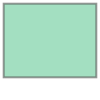

In [43]:
FOOTPRINT = f.to_crs('epsg:4326').geometry[0].envelope
FOOTPRINT

In [44]:
FOOTPRINT.bounds

(-122.0206833, 49.0283579, -121.9534779, 49.0817932)

In [45]:
# Set up Stac Client
api = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
api

<Client id=microsoft-pc>

In [46]:
# CONFIG 
# -------------
TGT_BANDS =  ['nir08', 'swir16']#'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A']
YEARS = ['2017','2018','2019','2020','2021']
BEGIN_MONTH = '01'
END_MONTH = '12'
MAX_CLOUD = 10
READ_IN_CHUNK = 4096
RESOLUTION = 30
TEMPORAL_CHUNK = {'time': -1, 'band': 1, 'x': 128, 'y': 128}
SYNCHRONOUS = False # Write bands out one at a time - use if resources can't handle all bands at once for AOI
# -------------

In [47]:
item_dict = []
for year in YEARS:
    date_range = f'{year}-{BEGIN_MONTH}-01/{year}-{END_MONTH}-30'
    
    # Query the Planetary Computer STAC server with pystac_client
    print(f'[Querying] {year}')
    items = api.search(
        collections = ['landsat-c2-l2'],
        intersects = FOOTPRINT,
        query={"eo:cloud_cover": {"lt": MAX_CLOUD},"platform":{"eq":"landsat-8"}},
        datetime = date_range,
    ).get_all_items()
    
    
    print(f'\tFound {len(items)} items')
    # planetarycomputer requires signed URLs to access Asset HREFs. 
    print('\t[Signing data links]')
    signed_items = [planetary_computer.sign(item).to_dict() for item in items]
    item_dict+=signed_items
        # Iterate over bands and build composite DAG
    # for band in TGT_BANDS:
    #     clear_output(wait=True) # clear Jupyter Cell output
    #     print(f'[Processing {band}]')
        
    # print(signed_items)

# Convert STAC query into a xarray.DataArray
# with stackstac
print('\t[Converting STAC query to DataArray]')
data = (
    stackstac.stack(
        item_dict,
        assets=TGT_BANDS, 
        chunksize=READ_IN_CHUNK, # Set chunksize
        resolution=RESOLUTION, # Set all bands res to this
        bounds_latlon=FOOTPRINT.bounds, # clip to AOI bounds
        epsg = 32610
    ).where(lambda x: x > 0.0, other=np.nan).assign_coords(
        #band=lambda x: x.common_name.rename("band"),  # use common names
        time=lambda x: x.time.dt.round(
            "D"
        ))  # r) # Convert nodata zero to np.nan
)
data

[Querying] 2017
	Found 7 items
	[Signing data links]
[Querying] 2018
	Found 8 items
	[Signing data links]
[Querying] 2019
	Found 5 items
	[Signing data links]
[Querying] 2020
	Found 9 items
	[Signing data links]
[Querying] 2021
	Found 6 items
	[Signing data links]
	[Converting STAC query to DataArray]


/srv/conda/envs/notebook/lib/python3.9/site-packages/stackstac/prepare.py:413: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  xs = pd.Float64Index(np.linspace(minx, maxx, width, endpoint=False))
/srv/conda/envs/notebook/lib/python3.9/site-packages/stackstac/prepare.py:414: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ys = pd.Float64Index(np.linspace(maxy, miny, height, endpoint=False))


<xarray.DataArray 'stackstac-31c67a2bed9eed70e82b28ca57af0bfc' (time: 35,
                                                                band: 2,
                                                                y: 201, x: 167)>
dask.array<where, shape=(35, 2, 201, 167), dtype=float64, chunksize=(1, 1, 201, 167), chunktype=numpy.ndarray>
Coordinates: (12/30)
  * time                         (time) datetime64[ns] 2017-01-04 ... 2021-09-03
    id                           (time) <U31 'LC08_L2SP_046026_20170103_02_T1...
  * band                         (band) <U6 'nir08' 'swir16'
  * x                            (x) float64 5.715e+05 5.715e+05 ... 5.765e+05
  * y                            (y) float64 5.437e+06 5.437e+06 ... 5.431e+06
    platform                     <U9 'landsat-8'
    ...                           ...
    title                        (band) <U28 'Near Infrared Band 0.8' 'Short-...
    raster:bands                 object {'scale': 2.75e-05, 'nodata': 0, 'off...
    common_name                  (band) <U6 'nir08' 'swir16'
    center_wavelength            (band) float64 0.87 1.61
    full_width_half_max          (band) float64 0.03 0.09
    epsg                         int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(571500, 5431050, 576510, 5437...
    crs:         epsg:32610
    transform:   | 30.00, 0.00, 571500.00|\n| 0.00,-30.00, 5437080.00|\n| 0.0...
    resolution:  30

### Storing data on the Dask Clusters

Once we have our data in an Xarray.Dataarray we will store the data on the Dask Clusters. To do this we will use **`.persist()`**.

**. .persist() executes the function call and returns a copy of each of the dask collections with the former lazy computations now submitted to run on the cluster. Here, the copy of the collection pointing to the Futures is returned immediately. When you run cell below you will see it complete execution almost instantly, but the progress bar, created by the `progress()` built-in function of "dask.distributed", shows the computation of tasks happening in the background on the dask clusters. Now, anymore queries on this persisted collection will be run very fast. 

There is *another* method called `client.compute()` which is similar to client.persist(), however this method returns only a single Future for each collection which must fit on a single worker machine. Client.compute() is ideal for smaller results that fit in memory, otherwise too large results would fail from blowing up memory space. So for our workflow, client.persist() should be used. 

In [48]:
data = data.persist()
progress(data)

VBox()

## 3. Calculating the NDWI

Now that we have all the data in the right place, let's compute the NDWI on the data! To efficiently get the NDWI for all the data, we will need a helper function to normalize our data first, similar to our method of computing NDVI.

### 3.1 Normalization Function

Normalization is a procedure of adjusting values measured on a different scale to a common scale. We will normalize the data so the computation of NDWI is done on the same scale of values. 

In [49]:
def normalize(array):
    norm = (array - array.min()) / (array.max() - array.min())
    return norm

In [50]:
normalized = normalize(data)

normalized

<xarray.DataArray 'stackstac-31c67a2bed9eed70e82b28ca57af0bfc' (time: 35,
                                                                band: 2,
                                                                y: 201, x: 167)>
dask.array<truediv, shape=(35, 2, 201, 167), dtype=float64, chunksize=(1, 1, 201, 167), chunktype=numpy.ndarray>
Coordinates: (12/30)
  * time                         (time) datetime64[ns] 2017-01-04 ... 2021-09-03
    id                           (time) <U31 'LC08_L2SP_046026_20170103_02_T1...
  * band                         (band) <U6 'nir08' 'swir16'
  * x                            (x) float64 5.715e+05 5.715e+05 ... 5.765e+05
  * y                            (y) float64 5.437e+06 5.437e+06 ... 5.431e+06
    platform                     <U9 'landsat-8'
    ...                           ...
    title                        (band) <U28 'Near Infrared Band 0.8' 'Short-...
    raster:bands                 object {'scale': 2.75e-05, 'nodata': 0, 'off...
    common_name                  (band) <U6 'nir08' 'swir16'
    center_wavelength            (band) float64 0.87 1.61
    full_width_half_max          (band) float64 0.03 0.09
    epsg                         int64 32610

### 3.2 Load Data Function

With the normalization function ready, we can now construct the main function for calculating the NDWI of every raster set. The function `lazy_get_data()` takes in the path of each image's individual URL for band 3 and band 5 and the Dask chunk sizes. Dask divides arrays into many small chunks that are small enough to fit into memory. Since our Geotiff images have 256 x 256 blocksize and we have over 200 files to process, let's set our chunksize to 8192 x 8192 (a larger multiple of the tile size).


The next step is to load the url into a Xarray DataArray in the assigned chunksize. The `.squeeze()` removes dimensions of length 1, and the `.drop(label='band')` removes the band from coordinates of the DataArray. 

This function is wrapped in a **Dask delayed** so that they operate lazily. It parallelizes the algorithm by placing the function and its arguments into a task graph instead of immediately executing the function.

In [ ]:
# @dask.delayed
# def lazy_get_data(B3, B5, chunks={'band': 1, 'x': 8192, 'y': 8192}):
#     # Read in the band url as an Xarray DataArray, getting rid of unneccessary dimensions
#     green = xr.open_rasterio(B3, chunks=chunks).squeeze().drop(labels='band')
#     nir = xr.open_rasterio(B5, chunks=chunks).squeeze().drop(labels='band')
    
#     return (green, nir)

### 3.3 Calculate the NDWI of each granule

Once the DataArrays are created, we will normalize them using the helper function created above. The last step in this function is to calculate and return the NDWI using the normalized green and NIR DataArrays.

In [19]:
def get_NDWI(green, nir):
    
    # #Normalize the data
    # greenN = normalize(green)
    # nirN = normalize(nir)
    
    # Calculate the NDWI
    ndwi = (green - nir) / (green + nir)
    
    return ndwi


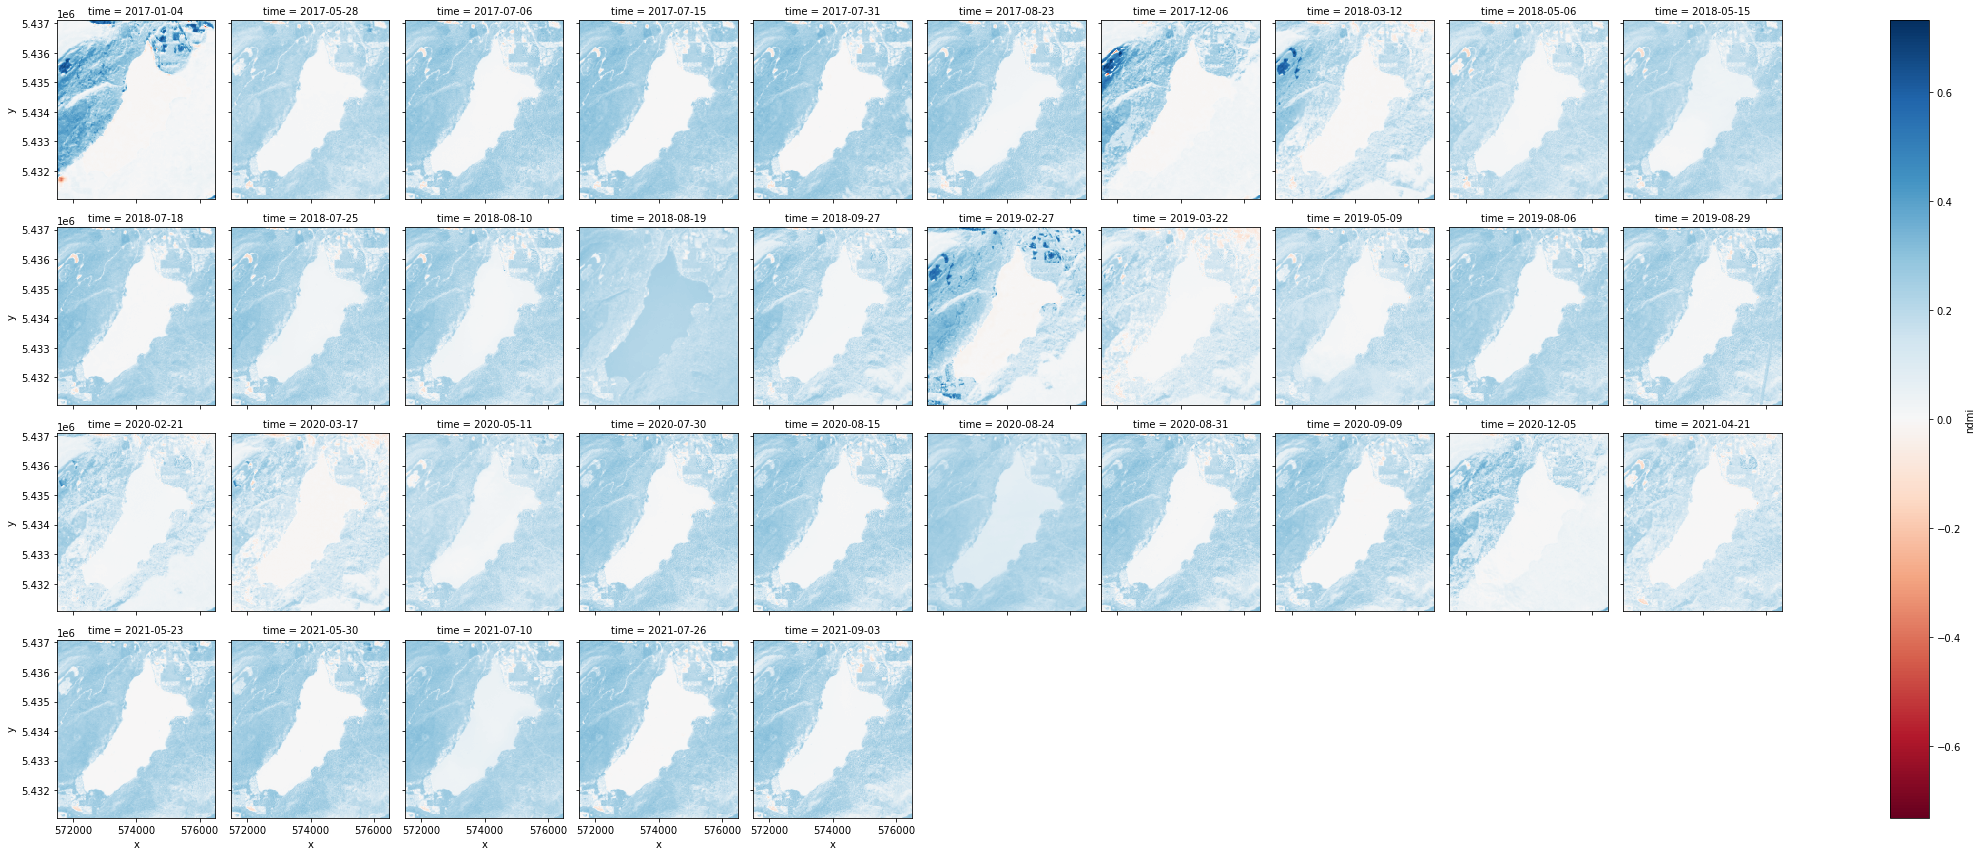

In [51]:
ndwi_aggs = [ms.ndmi(x.sel(band="nir08"), x.sel(band="swir16")) for x in data]

ndwi = xr.concat(ndwi_aggs, dim="time")

ndwi.plot.imshow(x='x',y='y',col="time", col_wrap=10, cmap="RdBu");

### 3.4 Executing and storing data on the Dask Clusters

The cell below runs the functions above to get the NDWI of each row from the dataframe created in Part 2. The results from the function call are appended to a list containing the NDWI of every granule.

The most important aspect of this computation is the **`client.persist()`**. The Client.persist() executes the function call and returns a copy of each of the dask collections with the former lazy computations now submitted to run on the cluster. Here, the copy of the collection pointing to the Futures is returned immediately. When you run cell below you will see it complete execution almost instantly, but the progress bar, created by the `progress()` built-in function of "dask.distributed", shows the computation of tasks happening in the background on the dask clusters. Now, anymore queries on this persisted collection will be run very fast. 

There is *another* method called `client.compute()` which is similar to client.persist(), however this method returns only a single Future for each collection which must fit on a single worker machine. Client.compute() is ideal for smaller results that fit in memory, otherwise too large results would fail from blowing up memory space. So for our workflow, client.persist() should be used. 


In [ ]:
%%time

delayed_downloads = []
for i,row in landsat_df.iterrows():
    delayed_downloads.append(lazy_get_data(row['B3'], row['B5']))
    
delayed_ndwi = []
for band in delayed_downloads:
    delayed_ndwi.append(get_NDWI(band[0], band[1]))

### 3.5 Combine the NDWI of all granules together in one DataArray

The next step is to concatenate the list of DataArrays from the previous step with their respective dates into a Xarray DataArray. 

In [ ]:
delayed_ndwi_concat = dask.delayed(xr.concat)(delayed_ndwi, dim=pd.DatetimeIndex(landsat_df['date'], name='time'))
delayed_ndwi_concat

In [ ]:
%%time
NDWI = delayed_ndwi_concat.compute().persist()
progress(NDWI)

In [ ]:
print('Dataset size (Gb): ', ndwi.nbytes/1e9)
ndwi

If you head over to the Dask Dashboard, you should notice the Datarray bytes are stored on the clusters.

## 4. Visualizing the Results

### 4.1 Plotting

To see how the NDWI changes over time, we can visualize it using HoloViz's **hvplot**.

The cell below groups the images according to time and plots the entire dataset.

In [30]:
%%time

# Creates gif 
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))

def animate(i):
    ax.imshow(ndwi[i], cmap='RdYlBu', clim=(0,1))
    ax.set_title("Date: {}".format(ndwi[i]), fontsize=30)
    ax.set_axis_off()

anim = FuncAnimation(fig, animate, frames=np.arange(len(ndwi)), interval=80)
anim.save('NDWI_anim_2016-2021.gif', dpi=50, writer='pillow')
plt.close()

CPU times: user 18.2 s, sys: 687 ms, total: 18.8 s
Wall time: 19.6 s


### 4.2 Analysis

The NDWI in the region North of Vancouver Island shows change over 8 years. This change can be useful in detecting significant changes in the water bodies off the region and be used as early warning to geographic events, such as droughts, floodings, and tsunamis.   

The pattern of change occurs seasonally, as can be seen in the plot above when the water contents in the land surface is much higher in the cooler months of the year, contrasting the drier surfaces with less water bodies in the summer months. 

In [57]:
#UTM zone 18N coordinates near Regina
xcen = 574035.66 #712641
ycen = 5433875.43 #5592001
buf = 1000  # look at point +/- 1km

In [58]:
annual = ndwi.sel(x=slice(xcen-buf,xcen+buf), y=slice(ycen-buf,ycen+buf), time=slice('2020-01-01', '2021-01-01'))
annual_timeseries = annual.resample(time='1MS').mean().persist()

annual_timeseries.isel(x=1,y=1).plot.line(figsize=(10,4), marker='.')
plt.title("Annual change of NDWI (2020)")

IndexError: index 1 is out of bounds for axis 1 with size 0

In [56]:
full_variation = NDWI.sel(x=slice(xcen-buf,xcen+buf), y=slice(ycen-buf,ycen+buf))
full_timeseries = full_variation.resample(time='1MS').mean().persist()

full_timeseries.isel(x=1,y=1).plot(figsize=(10,4), marker='.')
plt.title("NDVI Variation over 6 years")

NameError: name 'NDWI' is not defined

***Make sure to always explicitly shut down computing resources when you're not using them!***

In [60]:
cluster.shutdown()
client.close()
os.remove(poly_file_pth)